In [1]:
from keras.callbacks import ModelCheckpoint

import numpy
import math
import cv2
import time

from utility.h5data import h5DataRead

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Training config

In [2]:
EPOCHS = 1
BATCH_SIZE = 128

SCALE = 4
SIZE_PATCH = 64
SIZE_CONV = 6

FILENAME_TRAIN = "yayoi_srcnn_dataTrain_" + str(SCALE) + "_"+ str(SIZE_PATCH) + "_"+ str(SIZE_CONV) + ".h5"
FILENAME_VALIDATE = "yayoi_srcnn_dataValidate_" + str(SCALE) + "_"+ str(SIZE_PATCH) + "_"+ str(SIZE_CONV) + ".h5"
FILENAME_CHECKPOINT = "yayoi_srcnn_dataCheckPoint_" + str(SCALE) + ".h5"

In [3]:
# dnn configuration for srcnn
from network.srcnn import srcnn
dnn = srcnn()
dnn.layers = 3
dnn.inputShape = (SIZE_PATCH, SIZE_PATCH, 1)
dnn.filter = [128, 64, 1]
dnn.kernelSize =  [(9,9), (5,5), (5,5)]
dnn.in_train = True

In [4]:
tick1 = cv2.getTickCount()

In [6]:
model = dnn.network()
print(model.summary())
data, label = h5DataRead(FILENAME_TRAIN)
val_data, val_label = h5DataRead(FILENAME_VALIDATE)

checkpoint = ModelCheckpoint(FILENAME_CHECKPOINT, monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='min')

callbacks_list = [checkpoint]

model.fit(data, label, batch_size=BATCH_SIZE, validation_data=(val_data, val_label),
                callbacks=callbacks_list, shuffle=True, epochs=EPOCHS, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 56, 56, 128)       10496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        204864    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 1)         1601      
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
_________________________________________________________________
None
Train on 7513 samples, validate on 600 samples
Epoch 1/1
7513/7513 [==============================] - 2031s 270ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0056 - val_mean_squared_error: 0.0056

Epoch 00001: val_loss improved from inf to 0.00563, saving model to yayoi_srcnn_dataCheckPoint_4.h5


In [7]:
score = model.evaluate(val_data, val_label, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

600/600 [==============================] - 59s 98ms/step
Test loss: 0.005625411781171957
Test accuracy: 0.005625332283476989


### Save weight

In [8]:
fileName = 'yayoi_srcnn_' + str(SCALE) + "x_weight_" + time.strftime("%Y-%m-%d_%H%M%S", time.localtime()) + '.h5'
model.save_weights(fileName)
print(fileName + ' saved')

yayoi_srcnn_4x_weight_2018-09-13_060849.h5 saved


In [9]:
tick2 = cv2.getTickCount()
tick = math.floor( ((tick2 - tick1) * 1000) / cv2.getTickFrequency())

if tick >= 60000:
    mins = math.floor(tick / 60000)
    secs = math.floor((tick - mins * 60000) / 1000)
    msec = tick - mins * 60000 - secs * 1000
    print("Training processed time: " + str(mins) + " mins " + str(secs) + " secs " + str(msec) + " ms")
elif tick >= 1000:
    secs = math.floor(tick / 1000)
    msec = tick - secs * 1000
    print("Training processed time: " + str(secs) + " secs " + str(msec) + " ms")
else:
    print("Training processed time: " + str(tick) + " ms")

Training processed time: 36 mins 40 secs 473 ms


### Inference for test

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [11]:
IMG_NAME = "./imageTrain/yayoi_first_030.png"
IMG_OPENCV_NAME = "opencv.png"
IMG_DNN_NAME = "srcnn.png"

INTERPOLATION = cv2.INTER_CUBIC

In [12]:
dnn.in_train = False
model = dnn.network()
model.load_weights(fileName)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 1)     1601      
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
_________________________________________________________________
None


### Save model

In [13]:
fileName = 'yayoi_srcnn_' + str(SCALE) + "x_model_" + time.strftime("%Y-%m-%d_%H%M%S", time.localtime()) + '.h5'
model.save(fileName)
print(fileName + " save complete")

yayoi_srcnn_4x_model_2018-09-13_060850.h5 save complete


### Save model to Json

In [22]:
fileName = 'yayoi_srcnn_' + str(SCALE) + "x_network_" + time.strftime("%Y-%m-%d_%H%M%S", time.localtime()) + '.json'
    
model_json = model.to_json()
with open(fileName, "w") as json_file:
    json_file.write(model_json)
    print(fileName + " save complete")

yayoi_srcnn_4x_network_2018-09-13_061357.json save complete


In [16]:
tick1 = cv2.getTickCount()

In [17]:
img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
shape = img.shape

Y_img = cv2.resize(img[:, :, 0], (int(shape[1] / SCALE), int(shape[0] / SCALE)), cv2.INTER_CUBIC)
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
img[:, :, 0] = Y_img

img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(IMG_OPENCV_NAME, img, [int(cv2.IMWRITE_PNG_COMPRESSION), 0])

True

In [18]:
Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
Y[0, :, :, 0] = Y_img.astype(float) / 255.

pre = model.predict(Y, batch_size=1) * 255.
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0

pre = pre.astype(numpy.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

if SIZE_CONV > 0:
    img[SIZE_CONV: -SIZE_CONV, SIZE_CONV: -SIZE_CONV, 0] = pre[0, :, :, 0]
else:
    img[2:-2, 2:-2, 0] = pre[0, :, :, 0]

img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(IMG_DNN_NAME, img, [int(cv2.IMWRITE_PNG_COMPRESSION), 0])

True

In [19]:
# PSNR calculation
im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread(IMG_OPENCV_NAME, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.imread(IMG_DNN_NAME, cv2.IMREAD_COLOR)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

print("opencv:")
print(cv2.PSNR(im1, im2))
print("srcnn:")
print(cv2.PSNR(im1, im3))

opencv:
32.85164398482549
srcnn:
31.437597669086937


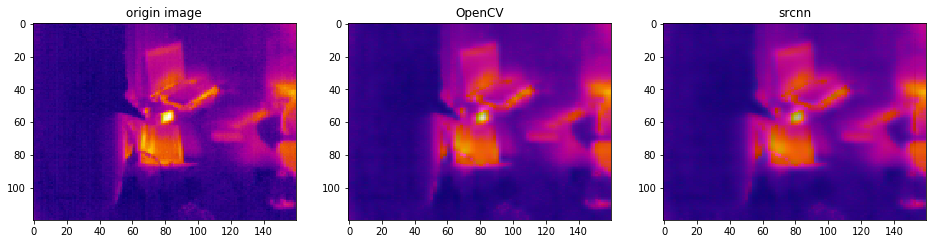

In [20]:
# display image
pltShow = True

if pltShow:
    plt.figure(num='comparison',figsize=(16,16))

    plt.subplot(1,3,1)
    plt.title('origin image')
    plt.imshow(im1)

    plt.subplot(1,3,2)
    plt.title('OpenCV')
    plt.imshow(im2)

    plt.subplot(1,3,3)
    plt.title('srcnn')
    plt.imshow(im3)

In [21]:
tick2 = cv2.getTickCount()
tick = math.floor( ((tick2 - tick1) * 1000) / cv2.getTickFrequency())

if tick >= 60000:
    mins = math.floor(tick / 60000)
    secs = math.floor((tick - mins * 60000) / 1000)
    msec = tick - mins * 60000 - secs * 1000
    print("Inference processed time: " + str(mins) + " mins " + str(secs) + " secs " + str(msec) + " ms")
elif tick >= 1000:
    secs = math.floor(tick / 1000)
    msec = tick - secs * 1000
    print("Inference processed time: " + str(secs) + " secs " + str(msec) + " ms")
else:
    print("Inference processed time: " + str(tick) + " ms")

Inference processed time: 2 secs 56 ms
